# E-commerce Purchase Prediction Notebook

This notebook generates a synthetic e-commerce sessions dataset and demonstrates an end-to-end ML workflow to predict whether a session results in a purchase. It includes EDA, preprocessing, model training (Logistic Regression and Random Forest), evaluation, and saving the best model.

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import *

sns.set_style('whitegrid')
sns.set_palette('husl')

# We will generate a synthetic dataset below.

### Synthetic dataset generation — intent and details

This explanatory cell describes the upcoming synthetic-data generation code.

What the next code cell will do:
- Create a reproducible synthetic dataset of 15,000 session rows using a fixed random seed.
- Generate session-level numeric features (session length, pages viewed, product views, cart additions, previous purchases), price and discount values drawn from realistic distributions, and categorical features (device, time of day, referral, day of week).
- Build a logistic-style scoring function that combines features with weights to produce a probability of purchase, add noise, and sample a binary `purchase` target.
- Assemble the features into a pandas DataFrame named `df`.

Why this matters:
- The synthetic dataset mimics typical e-commerce session logs and gives us a safe reproducible dataset to develop the full ML pipeline.

In [20]:
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

n = 3000
user_id = np.random.randint(1000, 9999, size=n)
session_id = np.arange(1, n+1)
session_length = np.random.exponential(180, n).astype(int)
pages_viewed = np.clip(np.random.poisson(5, n), 1, None)
product_views = np.clip(np.random.poisson(3, n), 0, None)
cart_adds = np.random.binomial(product_views, 0.15)
prev_purchases = np.random.poisson(1.0, n)
device = np.random.choice(['mobile', 'desktop', 'tablet'], n, p=[0.6, 0.3, 0.1])
time_of_day = np.random.choice(['morning', 'afternoon', 'evening', 'night'], n, p=[0.25,0.35,0.3,0.1])
price = np.round(np.random.lognormal(3.5, 1.0, n), 2)
discount = np.round(np.random.beta(1.5, 10, n) * 0.5, 2)
is_promo = np.random.binomial(1, 0.12, n)
referral = np.random.choice(['organic','ad','email','social'], n, p=[0.6,0.15,0.15,0.1])
day_of_week = np.random.randint(0,7,n)

score = -3.0 + 0.01*session_length + 0.15*pages_viewed + 0.25*product_views + 0.8*(cart_adds>0) + 0.2*prev_purchases - 0.0006*price + 0.8*is_promo + 0.4*(device=='desktop')
prob = np.clip(1/(1 + np.exp(-score)) * (1 + np.random.normal(0, 0.15, n)), 0, 1)
purchase = np.random.binomial(1, prob)

df = pd.DataFrame({
    'user_id': user_id, 'session_id': session_id, 'session_length': session_length,
    'pages_viewed': pages_viewed, 'product_views': product_views, 'cart_adds': cart_adds,
    'prev_purchases': prev_purchases, 'device': device, 'time_of_day': time_of_day,
    'price': price, 'discount': discount, 'is_promo': is_promo, 'referral': referral,
    'day_of_week': day_of_week, 'purchase': purchase
})

### Data Cleaning and Quality Checks

The next cell will perform data cleaning operations:
1. Check for missing values
2. Handle outliers in numeric columns
3. Validate data types
4. Clean text fields
5. Remove duplicates
6. Handle inconsistent categories

In [21]:
numeric_cols = ['session_length', 'pages_viewed', 'product_views', 'cart_adds', 'prev_purchases', 'price', 'discount']
categorical_cols = ['device', 'time_of_day', 'referral']

df[categorical_cols] = df[categorical_cols].astype('category')
df[categorical_cols] = df[categorical_cols].apply(lambda x: x.str.strip().str.lower())

for col in numeric_cols:
    Q1, Q3 = df[col].quantile([0.25, 0.75])
    IQR = Q3 - Q1
    df[col] = df[col].clip(Q1 - 1.5*IQR, Q3 + 1.5*IQR)

df = df.drop_duplicates()
df.loc[df['discount'] > 1, 'discount'] = 1
df.loc[df['discount'] < 0, 'discount'] = 0
df['day_of_week'] = df['day_of_week'].clip(0, 6)

### Initial data inspection — what we'll check and why

- Print dataset shape (rows, columns) and call `df.info()` to check dtypes and non-null counts.
- Show summary statistics (`df.describe(include='all')`) to review distributions for numeric and categorical columns.
- Print the target (`purchase`) class balance to assess label skew.

Why this matters:
- Quick checks reveal data issues (missing values, wrong dtypes, extreme skew) that guide cleaning and feature engineering choices.

Inputs: DataFrame `df` from the synthetic-data cell.
Outputs: human-readable prints and summary tables to inspect data health and class balance.


In [22]:
print('rows,cols:', df.shape)
df.info()

display(df.describe(include='all'))

print('\nTarget distribution:')
print(df['purchase'].value_counts(normalize=True))


rows,cols: (3000, 15)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3000 non-null   int32  
 1   session_id      3000 non-null   int64  
 2   session_length  3000 non-null   float64
 3   pages_viewed    3000 non-null   float64
 4   product_views   3000 non-null   int32  
 5   cart_adds       3000 non-null   float64
 6   prev_purchases  3000 non-null   int32  
 7   device          3000 non-null   object 
 8   time_of_day     3000 non-null   object 
 9   price           3000 non-null   float64
 10  discount        3000 non-null   float64
 11  is_promo        3000 non-null   int32  
 12  referral        3000 non-null   object 
 13  day_of_week     3000 non-null   int32  
 14  purchase        3000 non-null   int32  
dtypes: float64(5), int32(6), int64(1), object(3)
memory usage: 281.4+ KB


,user_id,session_id,session_length,pages_viewed,product_views,cart_adds,prev_purchases,device,time_of_day,price,discount,is_promo,referral,day_of_week,purchase
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000,3000,3000.000000,3000.000000,3000.000000,3000,3000.000000,3000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,4,NaN,NaN,NaN,4,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,mobile,afternoon,NaN,NaN,NaN,organic,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1815,1075,NaN,NaN,NaN,1803,NaN,NaN
mean,5516.240667,1500.500000,169.116667,5.002333,2.972000,0.433667,1.004667,NaN,NaN,48.328825,0.064067,0.130333,NaN,2.987000,0.621333
std,2577.731397,866.169729,148.309449,2.162341,1.694552,0.643354,1.010768,NaN,NaN,41.034003,0.045298,0.336726,NaN,2.022753,0.485136
min,1001.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,NaN,NaN,1.340000,0.000000,0.000000,NaN,0.000000,0.000000
25%,3223.500000,750.750000,52.000000,3.000000,2.000000,0.000000,0.000000,NaN,NaN,17.097500,0.030000,0.000000,NaN,1.000000,0.000000
50%,5588.500000,1500.500000,125.000000,5.000000,3.000000,0.000000,1.000000,NaN,NaN,33.760000,0.050000,0.000000,NaN,3.000000,1.000000
75%,7763.250000,2250.250000,249.000000,6.000000,4.000000,1.000000,2.000000,NaN,NaN,66.365000,0.090000,0.000000,NaN,5.000000,1.000000



Target distribution:
purchase
1    0.621333
0    0.378667
Name: proportion, dtype: float64


### Exploratory Data Analysis (EDA) — plots and interpretation

This explanatory cell describes the upcoming visualization code.

What the next code cell will do:
- Plot the target distribution (purchase vs no purchase) to visualize class imbalance.
- Plot a histogram of `session_length` to check for skew and outliers.
- Plot session counts by `device` to compare device mix.
- Compute and plot a correlation heatmap for numeric features to identify strongly related variables.

Why this matters:
- Visuals help identify relationships and distributions that inform feature engineering, scaling, and modeling choices.
- Checking correlations can reveal multicollinearity concerns or strong predictive signals.

Inputs: DataFrame `df`.
Outputs: matplotlib/seaborn plots displayed inline.


C:\Users\Bhavit\AppData\Local\Temp\ipykernel_20172\2978927661.py:26: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  purchase_by_price = df.groupby(price_bins)['purchase'].mean()


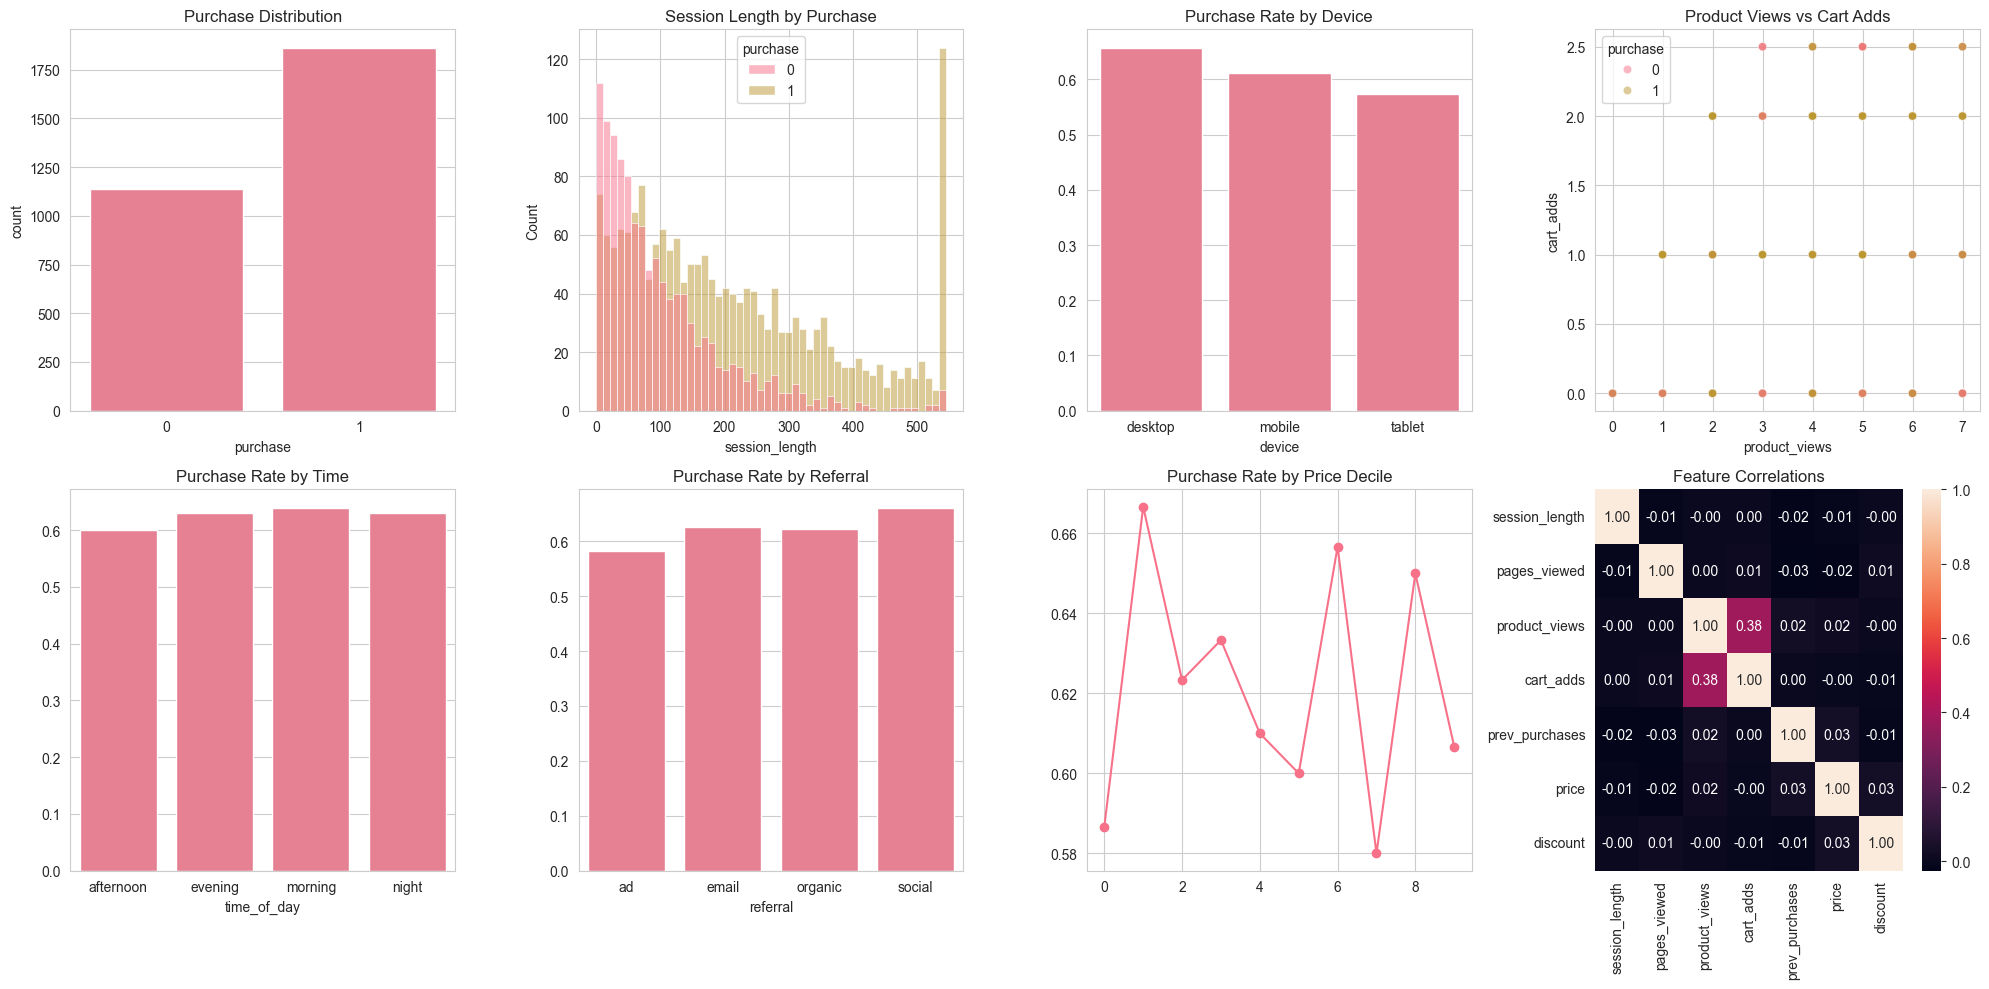

In [23]:
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
axes = axes.ravel()

sns.countplot(data=df, x='purchase', ax=axes[0])
axes[0].set_title('Purchase Distribution')

sns.histplot(data=df, x='session_length', hue='purchase', bins=50, ax=axes[1])
axes[1].set_title('Session Length by Purchase')

purchase_by_device = df.groupby('device')['purchase'].mean()
sns.barplot(x=purchase_by_device.index, y=purchase_by_device.values, ax=axes[2])
axes[2].set_title('Purchase Rate by Device')

sns.scatterplot(data=df, x='product_views', y='cart_adds', hue='purchase', alpha=0.5, ax=axes[3])
axes[3].set_title('Product Views vs Cart Adds')

time_purchase = df.groupby('time_of_day')['purchase'].mean()
sns.barplot(x=time_purchase.index, y=time_purchase.values, ax=axes[4])
axes[4].set_title('Purchase Rate by Time')

ref_purchase = df.groupby('referral')['purchase'].mean()
sns.barplot(x=ref_purchase.index, y=ref_purchase.values, ax=axes[5])
axes[5].set_title('Purchase Rate by Referral')

price_bins = pd.qcut(df['price'], 10)
purchase_by_price = df.groupby(price_bins)['purchase'].mean()
axes[6].plot(range(10), purchase_by_price.values, marker='o')
axes[6].set_title('Purchase Rate by Price Decile')

sns.heatmap(df[numeric_cols].corr(), annot=True, fmt='.2f', ax=axes[7])
axes[7].set_title('Feature Correlations')

plt.tight_layout()

### Preprocessing & Feature Encoding — plan and expectations

This explanatory cell describes the upcoming preprocessing code.

What the next code cell will do:
- Define the feature matrix X and the target y, excluding identifier columns (`user_id`, `session_id`) and the `purchase` column.
- Split the data into train and test sets (80/20) with a fixed random seed and stratification on the target to preserve class balance.
- Define numeric and categorical feature lists to apply different preprocessing steps.
- Build transformers:
  - Numeric: median imputation followed by StandardScaler.
  - Categorical: most-frequent imputation followed by OneHotEncoder (unknown categories handled).
- Combine transformers into a ColumnTransformer named `preprocessor` that can be used inside a scikit-learn Pipeline.

Why this matters:
- Consistent preprocessing inside a Pipeline prevents data leakage and keeps preprocessing tied to the model for reliable inference.

Inputs: DataFrame `df`.
Outputs: `X_train`, `X_test`, `y_train`, `y_test`, and a reusable `preprocessor` object.


In [24]:
X = df.drop(['user_id', 'session_id', 'purchase'], axis=1)
y = df['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y)

numeric_features = ['session_length', 'pages_viewed', 'product_views', 'cart_adds', 'prev_purchases', 'price', 'discount']
categorical_features = ['device', 'time_of_day', 'referral', 'day_of_week', 'is_promo']

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

### Model evaluation — metrics and ROC curve

This explanatory cell describes the upcoming evaluation code.

What the next code cell will do:
- For each model (Logistic Regression baseline and the best RandomForest), compute predictions and predicted probabilities on the test set.
- Calculate evaluation metrics: Accuracy, Precision, Recall, F1-score, ROC AUC, and display the confusion matrix.
- Plot ROC curves for both models for visual comparison of discrimination performance.

Why this matters:
- Using multiple metrics provides a fuller picture of performance, especially with class imbalance.
- ROC AUC measures ranking quality of probabilistic predictions; confusion matrices and precision/recall help assess operational impact.

Inputs: `best_model`, `log_pipe`, `X_test`, `y_test`.
Outputs: printed metrics, confusion matrices, and an ROC plot.



Logistic Regression Metrics:
Accuracy: 0.702
Precision: 0.811
Recall: 0.678
F1: 0.739
ROC AUC: 0.772
Confusion Matrix:
 [[168  59]
 [120 253]]


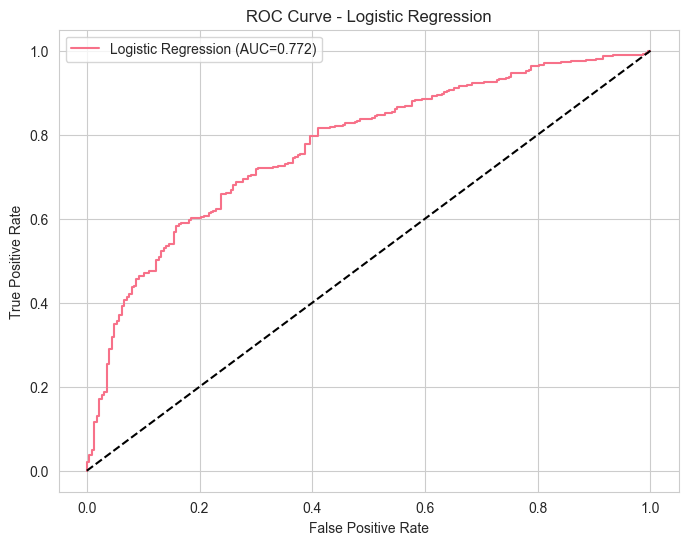

In [25]:
X_train_processed = preprocessor.fit_transform(X_train, y_train)

clf = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
clf.fit(X_train_processed, y_train)

X_test_processed = preprocessor.transform(X_test)

def print_model_metrics(model, X_proc, y_true):
    preds = model.predict(X_proc)
    probs = model.predict_proba(X_proc)[:, 1]
    
    print('\nLogistic Regression Metrics:')
    print(f'Accuracy: {accuracy_score(y_true, preds):.3f}')
    print(f'Precision: {precision_score(y_true, preds):.3f}')
    print(f'Recall: {recall_score(y_true, preds):.3f}')
    print(f'F1: {f1_score(y_true, preds):.3f}')
    print(f'ROC AUC: {roc_auc_score(y_true, probs):.3f}')
    print('Confusion Matrix:\n', confusion_matrix(y_true, preds))
    return probs

probs = print_model_metrics(clf, X_test_processed, y_test)

plt.figure(figsize=(8,6))
fpr, tpr, _ = roc_curve(y_test, probs)
plt.plot(fpr, tpr, label=f'Logistic Regression (AUC={auc(fpr,tpr):.3f})')
plt.plot([0,1], [0,1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend()